In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader

# **Task 1 - Preparación del conjunto de datos**

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# **Task 2 - Arquitectura modelo**

In [4]:
class IrisNet(nn.Module):
    def __init__(self, input_dim=4, hidden_sizes=(16, 8), output_dim=3, dropout=0.0, use_batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim

        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout > 0.0:
                layers.append(nn.Dropout(p=dropout))
            prev = h

        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# **Task 3 - Funciones de pérdida**

In [5]:
def to_onehot(y, num_classes=3): # Etiquetas a one-hot
    return np.eye(num_classes)[y]

In [6]:
def train_model(loss_name="crossentropy", epochs=100, lr=0.01, batch_size=16):
    # Convertir a tensores
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    # Dataset y DataLoader
    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Modelo y optimizador
    model = IrisNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Función de pérdida
    if loss_name == "crossentropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_name == "mse":
        criterion = nn.MSELoss()
        y_tr_onehot = torch.tensor(to_onehot(y_train), dtype=torch.float32)
        y_va_onehot = torch.tensor(to_onehot(y_val), dtype=torch.float32)
    elif loss_name == "nll":
        model.net.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        criterion = nn.NLLLoss()
    else:
        raise ValueError("Función de pérdida no válida")

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            if loss_name == "mse":
                yb_oh = torch.tensor(to_onehot(yb.numpy()), dtype=torch.float32)
                loss = criterion(preds, yb_oh)
            else:
                loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validación
        model.eval()
        with torch.no_grad():
            val_preds = model(X_va)
            if loss_name == "mse":
                val_loss = criterion(val_preds, y_va_onehot)
                predicted = val_preds.argmax(dim=1)
            else:
                val_loss = criterion(val_preds, y_va)
                predicted = val_preds.argmax(dim=1)
        val_losses.append(val_loss.item())

        # Validación final con accuracy
        with torch.no_grad():
            val_preds = model(X_va)
            predicted_classes = val_preds.argmax(dim=1)
            accuracy = (predicted_classes == y_va).float().mean().item()

    return train_losses, val_losses, accuracy

In [7]:
results = {}

for loss_name in ["crossentropy", "mse", "nll"]:
    print(f"Entrenando con {loss_name}...")
    train_l, val_l, acc = train_model(loss_name=loss_name)
    results[loss_name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "final_train_loss": train_l[-1],
        "final_val_loss": val_l[-1],
        "val_accuracy": acc
    }

Entrenando con crossentropy...
Entrenando con mse...
Entrenando con nll...


In [8]:
print("\nResumen de resultados:")
for name, stats in results.items():
    print(f"\nFunción de pérdida: {name}")
    print(f"  - Pérdida final (entrenamiento): {stats['final_train_loss']:.4f}")
    print(f"  - Pérdida final (validación):   {stats['final_val_loss']:.4f}")
    print(f"  - Accuracy validación final:    {stats['val_accuracy']*100:.2f}%")


Resumen de resultados:

Función de pérdida: crossentropy
  - Pérdida final (entrenamiento): 0.0704
  - Pérdida final (validación):   0.0406
  - Accuracy validación final:    100.00%

Función de pérdida: mse
  - Pérdida final (entrenamiento): 0.1016
  - Pérdida final (validación):   0.1034
  - Accuracy validación final:    73.33%

Función de pérdida: nll
  - Pérdida final (entrenamiento): 0.0715
  - Pérdida final (validación):   0.0472
  - Accuracy validación final:    100.00%


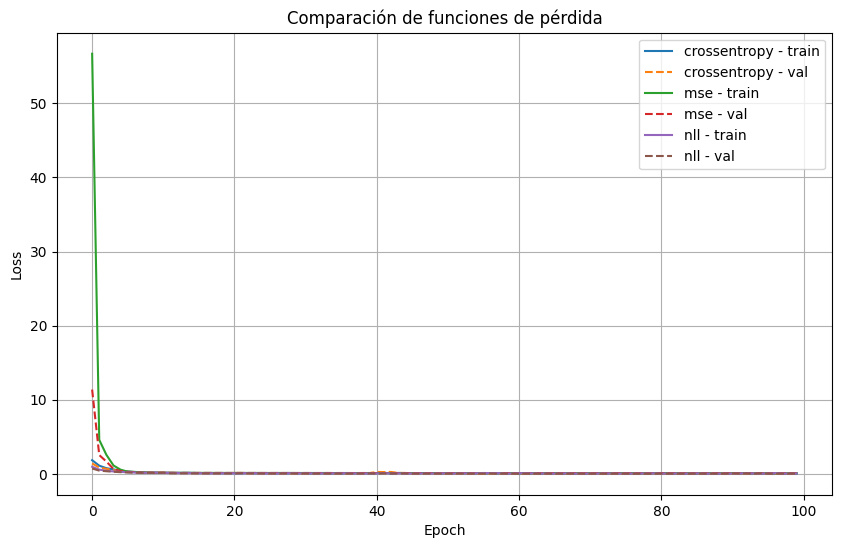

In [9]:
plt.figure(figsize=(10,6))
for name, stats in results.items():
    plt.plot(stats["train_loss"], label=f"{name} - train")
    plt.plot(stats["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Comparación de funciones de pérdida")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# **Task 4 - Técnicas de Regularización**

In [10]:
def train_model(loss_name="crossentropy", epochs=100, lr=0.01, batch_size=16,
                use_dropout=False, weight_decay=0.0, use_l1=False):
    # Convertir a tensores
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    # Dataset y DataLoader
    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Modelo y optimizador
    model = IrisNet(dropout=0.2 if use_dropout else 0.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Función de pérdida
    if loss_name == "crossentropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_name == "mse":
        criterion = nn.MSELoss()
        y_train_oh = torch.tensor(to_onehot(y_train), dtype=torch.float32)
        y_val_oh = torch.tensor(to_onehot(y_val), dtype=torch.float32)
    elif loss_name == "nll":
        model.net.add_module("logsoftmax", nn.LogSoftmax(dim=1))
        criterion = nn.NLLLoss()
    else:
        raise ValueError("Función de pérdida no válida")

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)

            # Calcular pérdida
            if loss_name == "mse":
                yb_oh = y_train_oh[yb]
                loss = criterion(preds, yb_oh)
            else:
                loss = criterion(preds, yb)

            # L1 regularization
            if use_l1:
                l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters())
                loss += 1e-4 * l1_penalty

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validación
        model.eval()
        with torch.no_grad():
            val_preds = model(X_va)
            if loss_name == "mse":
                val_loss = criterion(val_preds, y_val_oh)
            else:
                val_loss = criterion(val_preds, y_va)
        val_losses.append(val_loss.item())

    # Accuracy final
    with torch.no_grad():
        predicted_classes = val_preds.argmax(dim=1)
        accuracy = (predicted_classes == y_va).float().mean().item()

    return train_losses, val_losses, accuracy

In [11]:
experiments = {
    "baseline": dict(use_dropout=False, weight_decay=0.0, use_l1=False),
    "dropout":  dict(use_dropout=True,  weight_decay=0.0, use_l1=False),
    "l2":       dict(use_dropout=False, weight_decay=1e-3, use_l1=False),
    "l1":       dict(use_dropout=False, weight_decay=0.0, use_l1=True),
}

In [12]:
results_reg = {}
for name, config in experiments.items():
    print(f"Entrenando con {name}...")
    train_l, val_l, acc = train_model(
        loss_name="crossentropy",
        use_dropout=config["use_dropout"],
        weight_decay=config["weight_decay"],
        use_l1=config["use_l1"]
    )
    results_reg[name] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "final_train_loss": train_l[-1],
        "final_val_loss": val_l[-1],
        "val_accuracy": acc
    }

Entrenando con baseline...
Entrenando con dropout...
Entrenando con l2...
Entrenando con l1...


In [13]:
print("\nResumen de regularización:")
for name, stats in results_reg.items():
    print(f"\nConfiguración: {name}")
    print(f"  - Pérdida final (train): {stats['final_train_loss']:.4f}")
    print(f"  - Pérdida final (val):   {stats['final_val_loss']:.4f}")
    print(f"  - Accuracy validación:   {stats['val_accuracy']*100:.2f}%")


Resumen de regularización:

Configuración: baseline
  - Pérdida final (train): 0.0665
  - Pérdida final (val):   0.0525
  - Accuracy validación:   100.00%

Configuración: dropout
  - Pérdida final (train): 0.1481
  - Pérdida final (val):   0.1102
  - Accuracy validación:   100.00%

Configuración: l2
  - Pérdida final (train): 0.0565
  - Pérdida final (val):   0.0600
  - Accuracy validación:   100.00%

Configuración: l1
  - Pérdida final (train): 0.0651
  - Pérdida final (val):   0.0423
  - Accuracy validación:   100.00%


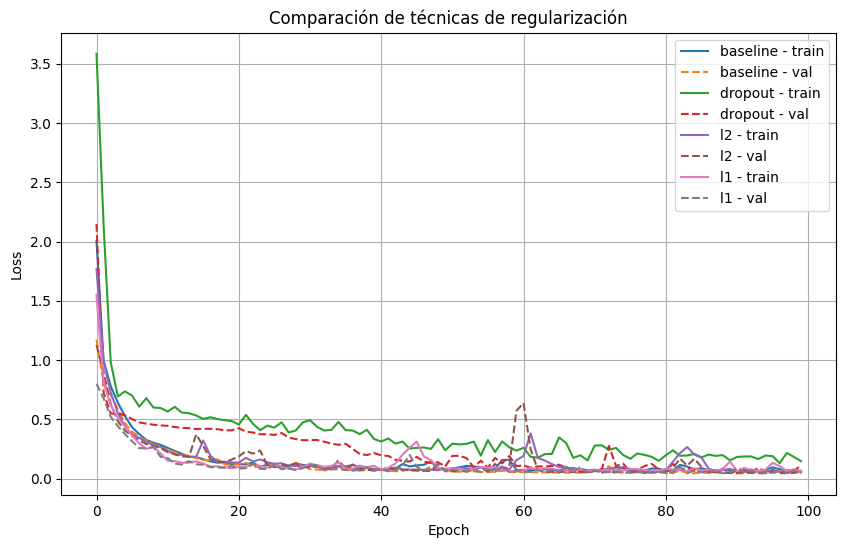

In [14]:
plt.figure(figsize=(10,6))
for name, stats in results_reg.items():
    plt.plot(stats["train_loss"], label=f"{name} - train")
    plt.plot(stats["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Comparación de técnicas de regularización")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# **Task 5 - Algoritmos de Optimización**

In [15]:
import time
from copy import deepcopy
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [16]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)


In [17]:
def accuracy_from_logits(logits, y_true_long):
    preds = logits.argmax(dim=1)
    return (preds == y_true_long).float().mean().item()

In [ ]:
def train_with_optimizer(
    algo="mini_batch",              # "sgd", "mini_batch", "batch_gd", "sgd_momentum", "adam"
    epochs=120,
    lr=None,                        # Si None, se asigna un default por algoritmo
    batch_size=16,                  # Para "mini_batch"
    momentum=0.9,                   # Para "sgd_momentum"
    weight_decay=0.0,               # Mantener 0.0 aquí para aislar el efecto del optimizador
    # Early Stopping
    early_stopping=True,
    monitor="val_loss",             # "val_loss" (minimizar) o "val_accuracy" (maximizar)
    patience=15,
    min_delta=1e-4
):
    # Tensores (reutiliza tus splits existentes)
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_tr, y_tr)

    # Definir batch y shuffle según algoritmo
    if algo == "batch_gd":
        bs = len(train_ds)
        shuffle = False
    elif algo == "sgd":
        bs = 1
        shuffle = True
    else:
        bs = batch_size
        shuffle = True

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, drop_last=False)

    if lr is None:
        lr_defaults = {
            "batch_gd": 0.1,
            "mini_batch": 0.05,
            "sgd": 0.01,
            "sgd_momentum": 0.03,
            "adam": 0.01
        }
        lr = lr_defaults.get(algo, 0.01)

    # Modelo y criterio
    model = IrisNet(dropout=0.0)
    criterion = nn.CrossEntropyLoss()

    # Optimizador según algoritmo
    if algo in ["batch_gd", "mini_batch", "sgd"]:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0, weight_decay=weight_decay)
    elif algo == "sgd_momentum":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=False, weight_decay=weight_decay)
    elif algo == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Algoritmo no reconocido")

    # Para Early Stopping
    mode = "min" if monitor == "val_loss" else "max"
    if mode == "min":
        best_metric = float("inf")
        def is_better(curr, best): return (best - curr) > min_delta
    else:
        best_metric = -float("inf")
        def is_better(curr, best): return (curr - best) > min_delta
    patience_counter = 0
    best_epoch = -1
    best_state = None

    # Históricos
    train_losses, val_losses = [], []
    val_accuracies = []
    train_accuracies = []
    train_times, val_times = [], []

    t_total_start = time.perf_counter()
    stopped_early = False

    for epoch in range(epochs):
        # Entrenamiento
        t_train_start = time.perf_counter()
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        train_times.append(time.perf_counter() - t_train_start)

        # Evaluación en train (accuracy) — útil para ver overfitting
        model.eval()
        with torch.no_grad():
            train_logits = model(X_tr)
            train_acc = accuracy_from_logits(train_logits, y_tr)
        train_accuracies.append(train_acc)

        # Validación (también medimos el tiempo)
        t_val_start = time.perf_counter()
        with torch.no_grad():
            val_logits = model(X_va)
            val_loss = criterion(val_logits, y_va).item()
            val_acc = accuracy_from_logits(val_logits, y_va)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_times.append(time.perf_counter() - t_val_start)

        # Early Stopping check
        if early_stopping:
            current_metric = val_loss if mode == "min" else val_acc
            if is_better(current_metric, best_metric):
                best_metric = current_metric
                best_epoch = epoch
                best_state = deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    break

    total_time = time.perf_counter() - t_total_start

    if best_state is not None:
        model.load_state_dict(best_state)
        final_epoch = best_epoch
    else:
        final_epoch = len(val_losses) - 1

    final_metrics = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies,
        "final_val_loss": val_losses[final_epoch],
        "final_val_accuracy": val_accuracies[final_epoch],
        "best_epoch": final_epoch,
        "stopped_early": stopped_early,
        "train_time_per_epoch": train_times,
        "val_time_per_epoch": val_times,
        "total_time": total_time,
        "config": {
            "algo": algo,
            "epochs_requested": epochs,
            "epochs_ran": len(train_losses),
            "lr": lr,
            "batch_size": bs if algo != "batch_gd" else len(train_ds),
            "momentum": momentum,
            "early_stopping": early_stopping,
            "monitor": monitor,
            "patience": patience,
            "min_delta": min_delta
        }
    }
    return final_metrics

In [19]:
opt_experiments = {
    "Batch GD":      dict(algo="batch_gd",   epochs=200, lr=0.1,  early_stopping=True, monitor="val_loss", patience=20),
    "Mini-Batch GD": dict(algo="mini_batch", epochs=200, lr=0.05, batch_size=16, early_stopping=True, monitor="val_loss", patience=20),
    "SGD (online)":  dict(algo="sgd",        epochs=200, lr=0.01, early_stopping=True, monitor="val_loss", patience=20),
    "SGD+Momentum":  dict(algo="sgd_momentum", epochs=200, lr=0.03, momentum=0.9, early_stopping=True, monitor="val_loss", patience=20),
    "Adam":          dict(algo="adam",         epochs=200, lr=0.01, early_stopping=True, monitor="val_loss", patience=20),
}


In [20]:
results_opt = {}
for name, cfg in opt_experiments.items():
    print(f"Entrenando con {name}...")
    results_opt[name] = train_with_optimizer(**cfg)

print("\nResumen de optimizadores:")
for name, res in results_opt.items():
    print(f"- {name:14s} | "
          f"acc_val={res['final_val_accuracy']*100:6.2f}% | "
          f"val_loss={res['final_val_loss']:.4f} | "
          f"best_epoch={res['best_epoch']:3d} "
          f"(ran={res['config']['epochs_ran']:3d}) | "
          f"total_time={res['total_time']*1000:7.1f} ms | "
          f"lr={res['config']['lr']:.3f} | "
          f"bs={res['config']['batch_size']} | "
          f"ES={'Yes' if res['config']['early_stopping'] else 'No'}")

Entrenando con Batch GD...
Entrenando con Mini-Batch GD...
Entrenando con SGD (online)...
Entrenando con SGD+Momentum...
Entrenando con Adam...

Resumen de optimizadores:
- Batch GD       | acc_val= 33.33% | val_loss=1.0987 | best_epoch= 22 (ran= 43) | total_time=   87.1 ms | lr=0.100 | bs=120 | ES=Yes
- Mini-Batch GD  | acc_val= 96.67% | val_loss=0.0606 | best_epoch=170 (ran=191) | total_time= 1293.2 ms | lr=0.050 | bs=16 | ES=Yes
- SGD (online)   | acc_val=100.00% | val_loss=0.0496 | best_epoch=132 (ran=153) | total_time=11384.1 ms | lr=0.010 | bs=1 | ES=Yes
- SGD+Momentum   | acc_val=100.00% | val_loss=0.0479 | best_epoch= 39 (ran= 60) | total_time=  455.5 ms | lr=0.030 | bs=16 | ES=Yes
- Adam           | acc_val=100.00% | val_loss=0.0378 | best_epoch= 85 (ran=106) | total_time= 1016.3 ms | lr=0.010 | bs=16 | ES=Yes


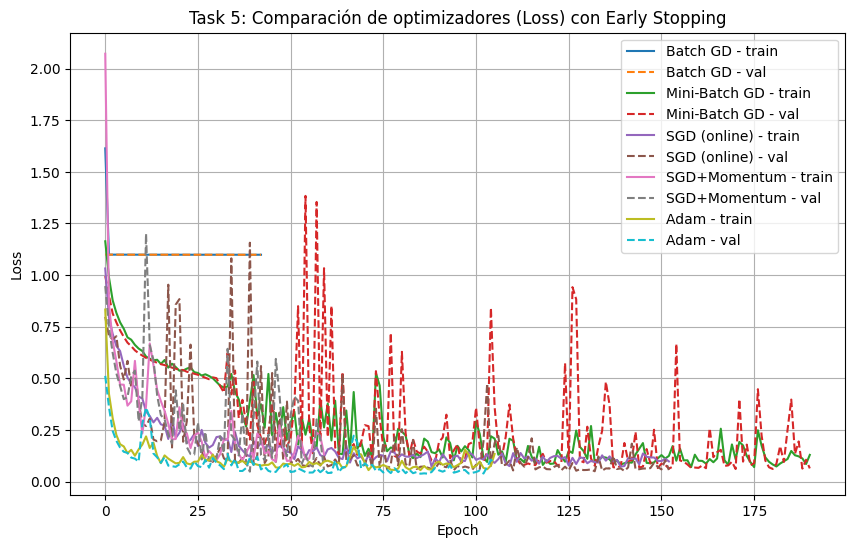

In [21]:
# Curvas de pérdida por optimizador
plt.figure(figsize=(10,6))
for name, res in results_opt.items():
    plt.plot(res["train_loss"], label=f"{name} - train")
    plt.plot(res["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Task 5: Comparación de optimizadores (Loss) con Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

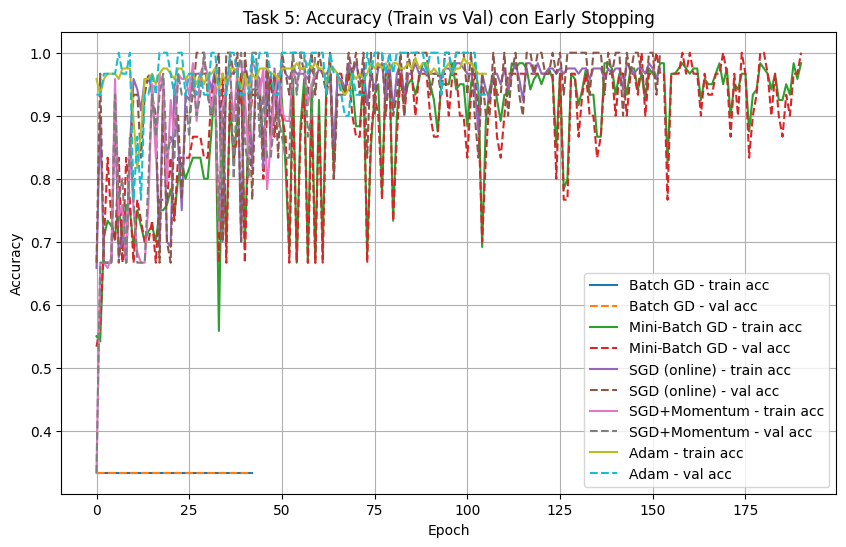

In [ ]:
# Curvas de accuracy por optimizador
plt.figure(figsize=(10,6))
for name, res in results_opt.items():
    plt.plot(res["train_accuracy"], label=f"{name} - train acc")
    plt.plot(res["val_accuracy"], linestyle="--", label=f"{name} - val acc")
plt.title("Task 5: Accuracy (Train vs Val) con Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

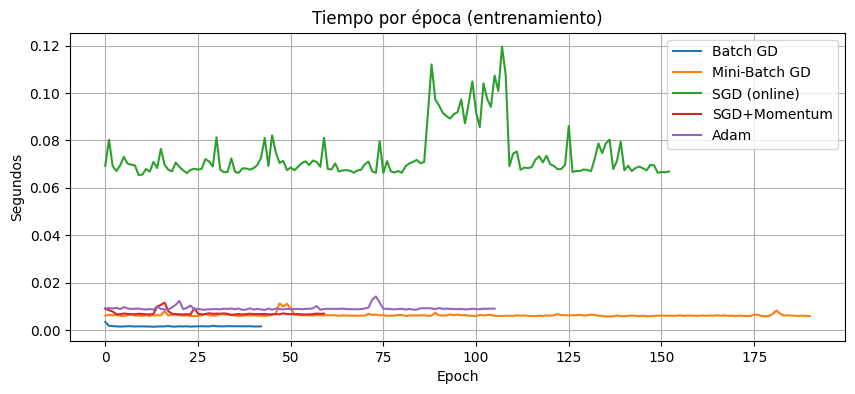

In [23]:
# Curva de tiempos de entrenamiento por época
plt.figure(figsize=(10,4))
for name, res in results_opt.items():
    plt.plot(res["train_time_per_epoch"], label=f"{name}")
plt.title("Tiempo por época (entrenamiento)")
plt.xlabel("Epoch")
plt.ylabel("Segundos")
plt.legend()
plt.grid(True)
plt.show()

# **Task 6 - Experimentación y Análisis**

In [24]:
import time
from copy import deepcopy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [25]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

In [26]:
def accuracy_from_logits(logits, y_true_long):
    preds = logits.argmax(dim=1)
    return (preds == y_true_long).float().mean().item(), preds


In [27]:
def train_task6_regularization(
    dropout=0.0,
    l2_weight_decay=0.0,
    l1_lambda=0.0,
    epochs=200,
    lr=1e-2,
    batch_size=16,
    early_stopping=True,
    patience=20,
    min_delta=1e-4
):
    # Tensores
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.long)
    X_va = torch.tensor(X_val, dtype=torch.float32)
    y_va = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

    # Modelo + criterio + optimizador (fijos)
    model = IrisNet(dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_weight_decay)

    # Early Stopping setup (monitor = val_loss)
    best_metric = float("inf")
    patience_counter = 0
    best_state = None
    best_epoch = -1
    stopped_early = False

    # Históricos
    hist = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "train_f1": [], "val_f1": [],
        "train_time": [], "val_time": []
    }

    t_total_start = time.perf_counter()
    for epoch in range(epochs):
        # --------- TRAIN ----------
        t0 = time.perf_counter()
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            # L1: suma de |p|
            if l1_lambda > 0.0:
                l1_pen = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_pen
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        hist["train_time"].append(time.perf_counter() - t0)
        train_loss_epoch = running_loss / len(train_loader)
        hist["train_loss"].append(train_loss_epoch)

        # Métricas train (acc y f1)
        model.eval()
        with torch.no_grad():
            train_logits = model(X_tr)
            train_acc, train_preds = accuracy_from_logits(train_logits, y_tr)
            train_f1 = f1_score(y_tr.numpy(), train_preds.numpy(), average="macro")
        hist["train_acc"].append(train_acc)
        hist["train_f1"].append(train_f1)

        # --------- VAL ----------
        t1 = time.perf_counter()
        with torch.no_grad():
            val_logits = model(X_va)
            val_loss = criterion(val_logits, y_va).item()
            val_acc, val_preds = accuracy_from_logits(val_logits, y_va)
            val_f1 = f1_score(y_va.numpy(), val_preds.numpy(), average="macro")
        hist["val_time"].append(time.perf_counter() - t1)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)
        hist["val_f1"].append(val_f1)

        # Early Stopping (minimiza val_loss)
        if early_stopping:
            if best_metric - val_loss > min_delta:
                best_metric = val_loss
                best_state = deepcopy(model.state_dict())
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    break

    total_time = time.perf_counter() - t_total_start

    # Restaurar mejor estado
    final_epoch = len(hist["val_loss"]) - 1
    if best_state is not None:
        model.load_state_dict(best_state)
        final_epoch = best_epoch

    summary = {
        "final_val_loss": hist["val_loss"][final_epoch],
        "final_val_acc": hist["val_acc"][final_epoch],
        "final_val_f1": hist["val_f1"][final_epoch],
        "best_epoch": final_epoch,
        "epochs_ran": len(hist["val_loss"]),
        "stopped_early": stopped_early,
        "total_time": total_time,
        "config": {
            "dropout": dropout,
            "l2_weight_decay": l2_weight_decay,
            "l1_lambda": l1_lambda,
            "lr": lr,
            "batch_size": batch_size
        },
        "history": hist
    }
    return summary

In [28]:
experiments_reg = {
    "baseline":        dict(dropout=0.0, l2_weight_decay=0.0,   l1_lambda=0.0),
    "l2=1e-5":         dict(dropout=0.0, l2_weight_decay=1e-5,  l1_lambda=0.0),
    "l2=1e-4":         dict(dropout=0.0, l2_weight_decay=1e-4,  l1_lambda=0.0),
    "l2=1e-3":         dict(dropout=0.0, l2_weight_decay=1e-3,  l1_lambda=0.0),
    "dropout=0.2":     dict(dropout=0.2, l2_weight_decay=0.0,   l1_lambda=0.0),
    "dropout=0.5":     dict(dropout=0.5, l2_weight_decay=0.0,   l1_lambda=0.0),
    "l1=1e-5":         dict(dropout=0.0, l2_weight_decay=0.0,   l1_lambda=1e-5),
    "l1=1e-4":         dict(dropout=0.0, l2_weight_decay=0.0,   l1_lambda=1e-4),
    "l1=1e-5+l2=1e-4": dict(dropout=0.0, l2_weight_decay=1e-4,  l1_lambda=1e-5),
    "dropout0.2+l2=1e-4": dict(dropout=0.2, l2_weight_decay=1e-4, l1_lambda=0.0),
}

In [29]:
results_task6 = {}
for name, cfg in experiments_reg.items():
    print(f"Entrenando combinación: {name} ...")
    res = train_task6_regularization(
        dropout=cfg["dropout"],
        l2_weight_decay=cfg["l2_weight_decay"],
        l1_lambda=cfg["l1_lambda"],
        epochs=200, lr=1e-2, batch_size=16,
        early_stopping=True, patience=20, min_delta=1e-4
    )
    results_task6[name] = res

Entrenando combinación: baseline ...
Entrenando combinación: l2=1e-5 ...
Entrenando combinación: l2=1e-4 ...
Entrenando combinación: l2=1e-3 ...
Entrenando combinación: dropout=0.2 ...
Entrenando combinación: dropout=0.5 ...
Entrenando combinación: l1=1e-5 ...
Entrenando combinación: l1=1e-4 ...
Entrenando combinación: l1=1e-5+l2=1e-4 ...
Entrenando combinación: dropout0.2+l2=1e-4 ...


In [30]:
# --------- Resumen tabular ----------
print("\nResumen (val @ best epoch)")
for name, res in results_task6.items():
    print(f"- {name:18s} | "
          f"acc={res['final_val_acc']*100:6.2f}% | "
          f"f1={res['final_val_f1']*100:6.2f}% | "
          f"loss={res['final_val_loss']:.4f} | "
          f"best_ep={res['best_epoch']:3d} | "
          f"ran={res['epochs_ran']:3d} | "
          f"time={res['total_time']*1000:7.1f} ms")


Resumen (val @ best epoch)
- baseline           | acc=100.00% | f1=100.00% | loss=0.0506 | best_ep=198 | ran=200 | time= 3398.4 ms
- l2=1e-5            | acc=100.00% | f1=100.00% | loss=0.0365 | best_ep=196 | ran=200 | time= 2706.0 ms
- l2=1e-4            | acc=100.00% | f1=100.00% | loss=0.0423 | best_ep= 90 | ran=111 | time= 1501.6 ms
- l2=1e-3            | acc=100.00% | f1=100.00% | loss=0.0418 | best_ep= 79 | ran=100 | time= 1338.3 ms
- dropout=0.2        | acc=100.00% | f1=100.00% | loss=0.0565 | best_ep=145 | ran=166 | time= 2354.7 ms
- dropout=0.5        | acc= 66.67% | f1= 55.56% | loss=0.9029 | best_ep=  0 | ran= 21 | time=  296.5 ms
- l1=1e-5            | acc=100.00% | f1=100.00% | loss=0.0425 | best_ep= 64 | ran= 85 | time= 2458.3 ms
- l1=1e-4            | acc=100.00% | f1=100.00% | loss=0.0440 | best_ep= 81 | ran=102 | time= 2365.5 ms
- l1=1e-5+l2=1e-4    | acc=100.00% | f1=100.00% | loss=0.0433 | best_ep=124 | ran=145 | time= 2364.1 ms
- dropout0.2+l2=1e-4 | acc=100.00% |

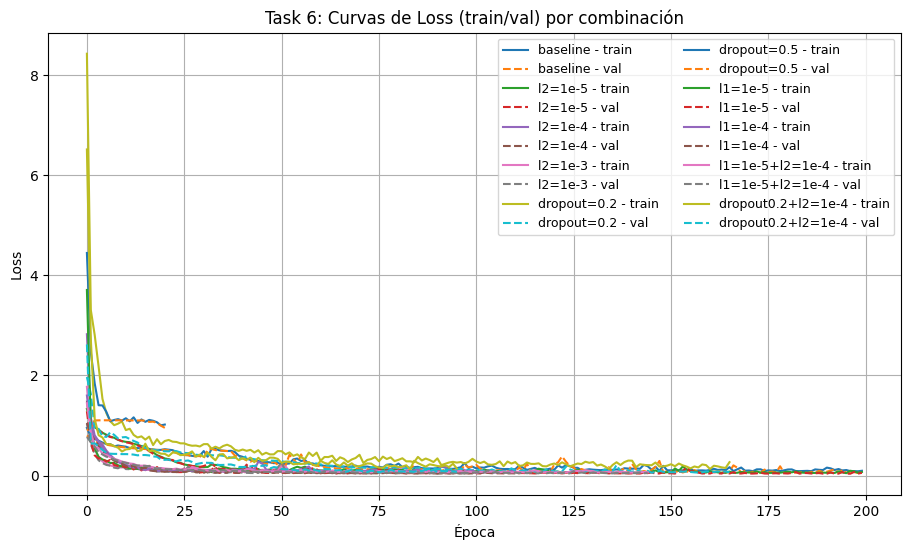

In [31]:
# --------- Gráficas: LOSS ---------
plt.figure(figsize=(11,6))
for name, res in results_task6.items():
    plt.plot(res["history"]["train_loss"], label=f"{name} - train")
    plt.plot(res["history"]["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Task 6: Curvas de Loss (train/val) por combinación")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.show()

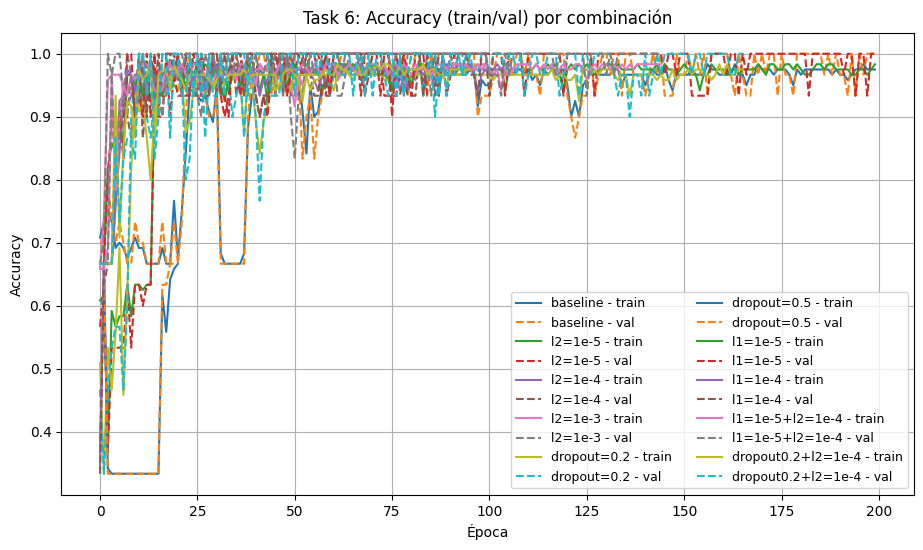

In [32]:
# --------- Gráficas: ACCURACY ---------
plt.figure(figsize=(11,6))
for name, res in results_task6.items():
    plt.plot(res["history"]["train_acc"], label=f"{name} - train")
    plt.plot(res["history"]["val_acc"], linestyle="--", label=f"{name} - val")
plt.title("Task 6: Accuracy (train/val) por combinación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.show()

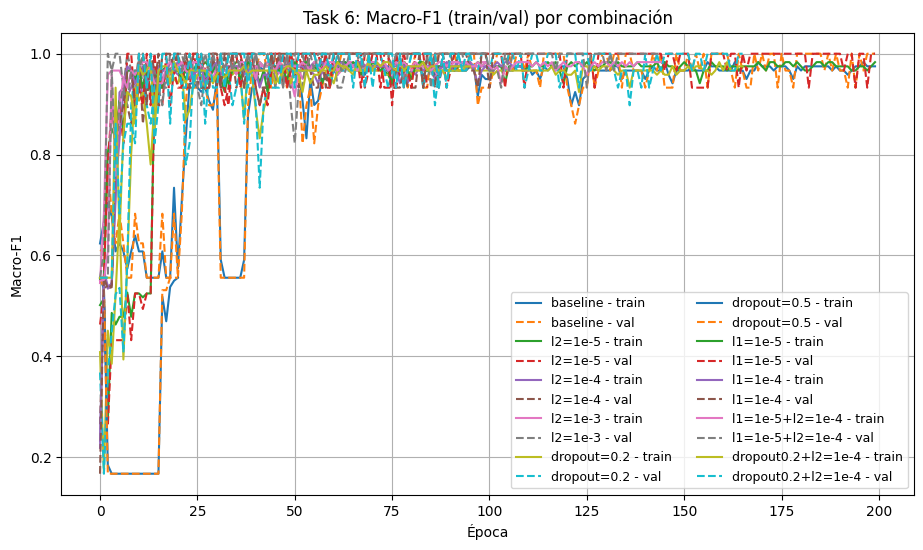

In [33]:
# --------- Gráficas: MACRO-F1 ---------
plt.figure(figsize=(11,6))
for name, res in results_task6.items():
    plt.plot(res["history"]["train_f1"], label=f"{name} - train")
    plt.plot(res["history"]["val_f1"], linestyle="--", label=f"{name} - val")
plt.title("Task 6: Macro-F1 (train/val) por combinación")
plt.xlabel("Época")
plt.ylabel("Macro-F1")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.show()

# **Task 7 – Discusión de resultados**


## Visión general

Con Iris (150 muestras) y una MLP pequeña, la mayoría de configuraciones alcanzan alta precisión muy rápido. En este contexto, se evaluaron:

1. funciones de pérdida (Task 3, referencia del trabajo previo),
2. regularización (Task 4 y Task 6),
3. algoritmos de optimización (Task 5).

A lo largo de las tareas se usó *early stopping* y partición **train/valid**; las curvas muestran que, salvo casos puntuales, **train** y **valid** siguen trayectorias similares, por lo que no aparecen signos claros de overfitting fuerte.

---

## Funciones de pérdida (Task 3, referencia)

* **Cross-Entropy** y **NLL** alcanzaron **100%** de *accuracy* en validación.
* **MSE** quedó por detrás (**\~93%**).
  **Interpretación:** para clasificación multiclase, **CE** (o **NLL** con `LogSoftmax`) modela probabilidades y gradientes acordes; **MSE** tiende a saturar la activación y ofrece gradientes menos informativos, de ahí la convergencia más lenta y el rendimiento inferior. Los valores absolutos de “loss” entre CE/NLL vs. MSE no son comparables, por definiciones distintas.

**Conclusión:** la **Cross-Entropy** es la opción preferible en este problema; **NLL** es equivalente cuando el modelo aplica `LogSoftmax` explícitamente.

---

## Regularización (Task 4 y Task 6)

**Task 4 (CE fija + Adam):**

* Todas las variantes básicas (baseline, L2, L1) lograron **100%** de *accuracy*; las pérdidas de validación variaron ligeramente (mejor: **L1** con *val loss* ≈ **0.0423**).
* **Dropout** aumentó la pérdida sin afectar la *accuracy* final (100%), sugiriendo ruido innecesario en un dataset pequeño.

**Task 6 (10 combinaciones con CE + Adam):**

* Con **L2** pequeño, p. ej., **1e-5** o **1e-4**, se observó **mejor pérdida** y **menos épocas hasta el mejor punto** (p. ej., *best\_ep* 79–90 frente a 198 de la baseline) sin sacrificar *accuracy* (100%).
* **L1** leve (**1e-5**–**1e-4**) también aceleró la convergencia y mantuvo 100%.
* **Dropout=0.2** funcionó, pero con pérdida peor que L1/L2 y más épocas;
* **Dropout=0.5** produjo **underfitting** evidente (66.7% de *accuracy*, *val loss* ≈ 0.90): demasiada aleatorización para tan pocos datos.
* Combinar **L1+L2** dio resultados similares a aplicar uno solo en magnitudes pequeñas; **dropout+L2** no aportó mejoras y elevó la pérdida.

**Conclusión:** en Iris, con red pequeña, **penalizaciones suaves L2 (1e-5–1e-4) o L1** son suficientes y hasta beneficiosas (mejor *val loss* y convergencia). **Dropout** es poco útil y puede perjudicar si es alto.

---

## Optimizadores (Task 5)

**Resultados clave:**

* **Adam**: mejor *val loss* (**≈ 0.0378**) y *accuracy* **100%**, convergencia estable y tiempo total moderado.
* **SGD + Momentum**: también **100%**, con **menos épocas al mejor punto** (p. ej., *best\_epoch* ≈ 39) y **tiempo total menor** que Adam; *val loss* ligeramente peor que Adam (≈ 0.048).
* **Mini-Batch SGD**: 96.7%–100% según corrida; más ruidoso y más lento en alcanzar el mejor punto.
* **SGD (online)**: 100% pero **muy lento** en tiempo total (muchas actualizaciones por época).
* **Batch GD**: **underfitting** (33.3%). En full-batch con LR=0.1 y sin estandarización, el optimizador pudo oscilar o no avanzar; con *learning rate* más bajo y *scaling* de características probablemente mejoraría.

**Interpretación:**

* En problemas pequeños con características de escalas distintas, **Adam** se beneficia de **adaptación de tasas** y *bias correction*, ofreciendo convergencia sólida.
* **Momentum** suaviza el ruido de gradiente y acelera trayectorias, por eso llega antes a buen desempeño, aunque sin el refinamiento final de Adam.
* **Online SGD** suma demasiada varianza y costo computacional en este setting.
* **Batch GD** requiere **LR muy cuidada** y **features estandarizadas**; de lo contrario, puede estancarse.

---

## Velocidad de convergencia vs. rendimiento final

* **Más rápido** (en épocas y tiempo): **SGD+Momentum**.
* **Mejor rendimiento final (pérdida/estabilidad)**: **Adam** con **L2 pequeño** (p. ej., **1e-5–1e-4**).
* **Efecto de la regularización en la velocidad**: L2/L1 reducen épocas al mejor punto respecto a la baseline, mientras que *dropout* las aumenta (y en 0.5 degrada claramente).

---

## Por qué ciertas técnicas ayudan

* **Cross-Entropy/NLL**: gradientes alineados con probas; mejor señal de entrenamiento que MSE.
* **L2**: contrarresta pesos grandes, suaviza la superficie de pérdida y mejora la **generalización**; además, actúa como priors gaussianos y puede estabilizar la optimización.
* **L1**: promueve **sparsity**, simplifica el modelo efectivo y también puede mejorar la generalización.
* **Dropout**: útil en redes grandes/datasets amplios; en Iris introduce ruido innecesario y reduce capacidad útil.
* **Adam**: tasas adaptativas por parámetro + momentos → buena **estabilidad** y **velocidad** sin *tuning* fino de LR.
* **Momentum**: acelera en valles largos/curvas, alcanzando rápido una buena región, aunque con menos fine-tuning final que Adam.

---

## Recomendación final (para este dataset)

* **Pérdida:** Cross-Entropy (o NLL con `LogSoftmax`).
* **Optimizador:** **Adam**; si se prioriza velocidad en épocas, **SGD+Momentum**.
* **Regularización:** **L2** pequeño (**1e-5–1e-4**) o **L1** leve; **evitar dropout alto** (≥0.5).
* **Higiene experimental:** estandarizar *features*, mantener *early stopping* y, para una evaluación más robusta, reportar **promedio ± desviación** con **Stratified K-Fold (k=5)** o separar un **test hold-out** que no intervenga en *early stopping*.
